# **Multiclass Classification Problem on CIFAR-10 Dataset**

**Case Study**

This project focuses on solving a multiclass classification problem using the CIFAR-10 dataset, a widely recognized benchmark dataset in evaluating different Machine Learning and Deep Learning models. The primary goal is to compare the effectiveness, performance, and training time of three models in classifying images into their respective categories.

The project explores in depth the following classification models and their unique approaches to the problem:
 - **Ridge Regression for Classification**: simplicity and interpretability.
 - **Random Forest**: ensemble-based power.
 - **Deep Convolutional Neural Network (CNN)**: advanced pattern recognition capabilities.

In addition to analyzing model performance and training time on the original dataset, the project also evaluates Ridge Regression and Random Forest on a Principal Component Analysis (PCA)-transformed version of the CIFAR-10 dataset. This comparison helps assess whether dimensionality reduction improves model performance or reduces training time.

# **Setup**

The Setup section includes the requisite code to initiate the project.

---
**Installing required libraries**

In [ ]:
!pip install plotly

---
**Libraries Imports**

In [ ]:
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import numpy as np

import copy
import random
from time import time

# **CIFAR-10 Dataset Analysis**

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.

The CIFAR-10 dataset contains 60,000 32x32 color images (RGB ranging from 0 to 255) in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

There are 6,000 images of each class between training and testing set, thus the dataset is considered balanced.

---
**Training, Testing & Validation sets creation**

In [ ]:
def load_cifar10_dataset(train_val_split: float = 0.8) -> tuple:
    """Imports the CIFAR-10 dataset and splits it into training, validation and testing sets.

    The sets are normalized and converted into float.

    Args:
        train_val_split: The ratio of the training set to the total dataset.

    Returns:
        tuple: A tuple containing the training, validation and testing sets.
    """
    # Imports the Cifar10 dataset
    cifar10 = tf.keras.datasets.cifar10

    # Splits the dataset into training set and testing set
    (X_train_original, y_train), (X_test_original, y_test) = cifar10.load_data()

    split = int(len(X_train_original) * train_val_split)

    # Splits the training set into training set and validation set
    X_train, X_val = X_train_original[:split], X_train_original[split:]
    y_train, y_val = y_train[:split], y_train[split:]

    # Normilizes the data using Z score and converts into float
    X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    X_test = (X_test_original - np.mean(X_test_original, axis=0)) / np.std(X_test_original, axis=0)
    X_val = (X_val - np.mean(X_val, axis=0)) / np.std(X_val, axis=0)

    # Prints datasets shapes and type of data
    print(f'Training set:\n\tShape: {X_train.shape}\n\tData type: {X_train.dtype}\n')
    print(f'Validation set:\n\tShape: {X_val.shape}\n\tData type: {X_val.dtype}\n')
    print(f'Testing set:\n\tShape: {X_test.shape}\n\tData type: {X_test.dtype}\n')

    return X_train_original, X_test_original, X_train, y_train, X_val, y_val, X_test, y_test


# Creates the training, testing and validation sets from CIFAR-10 dataset
X_train_original, X_test_original, X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10_dataset()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Training set:
	Shape: (40000, 32, 32, 3)
	Data type: float64

Validation set:
	Shape: (10000, 32, 32, 3)
	Data type: float64

Testing set:
	Shape: (10000, 32, 32, 3)
	Data type: float64



In [ ]:
def flatten_cifar10_dataset(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray) -> tuple:
    """Flattens the CIFAR-10 datasets.

    The flattened datasets are used for linear and ensemble models.
    The flattened datasets are also used for dimensionality reduction.

    Args:
        X_train: The training set.
        X_val: The validation set.
        X_test: The testing set.

    Returns:
        tuple: A tuple containing the flattened training, validation and testing sets.
    """
    # Flattens the datasets into N x (32 * 32 * 3) datasets
    X_train_f = X_train.reshape(X_train.shape[0], -1)
    X_val_f = X_val.reshape(X_val.shape[0], -1)
    X_test_f = X_test.reshape(X_test.shape[0], -1)

    # Prints datasets shapes and type of data
    print(f'Flattened training set:\n\tShape: {X_train_f.shape}\n\tData type: {X_train_f.dtype}\n')
    print(f'Flattened validation set:\n\tShape: {X_val_f.shape}\n\tData type: {X_val_f.dtype}\n')
    print(f'Flattened testing set:\n\tShape: {X_test_f.shape}\n\tData type: {X_test_f.dtype}\n')

    return X_train_f, X_val_f, X_test_f


# Flattens the sets
X_train_f, X_val_f, X_test_f = flatten_cifar10_dataset(X_train=X_train, X_val=X_val, X_test=X_test)

Flattened training set:
	Shape: (40000, 3072)
	Data type: float64

Flattened validation set:
	Shape: (10000, 3072)
	Data type: float64

Flattened testing set:
	Shape: (10000, 3072)
	Data type: float64



---
**Image Samples from CIFAR-10**

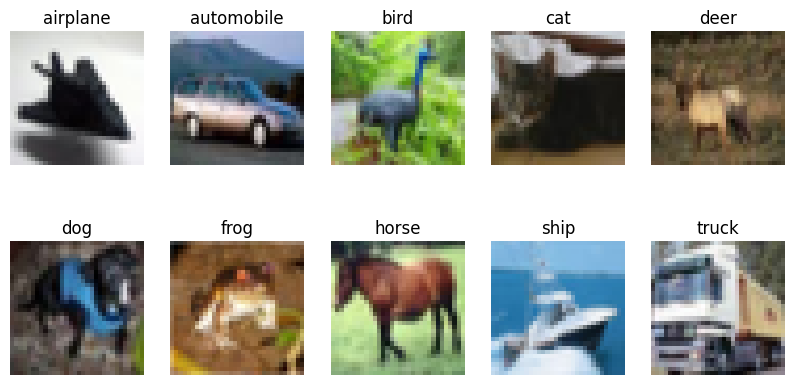

In [ ]:
def plot_class_images(X: np.ndarray, y: np.ndarray, classes_mapping: dict) -> None:
    """Plots an image with its label for each class in the dataset.

    Args:
        X: The image dataset.
        y: The labels of the image dataset.
        classes_mapping: A dictionary mapping the labels to their respective names.
    """
    plt.figure(figsize=(10, 5))

    # Finds the first image for each class
    class_images = {}
    for i in range(len(y)):
        class_label = y[i][0]
        if class_label not in class_images:
            class_images[class_label] = (X[i], classes_mapping[y[i][0]])

        if len(class_images) == 10:
            break

    # Plots the images and their class labels
    for class_label, (image, label) in class_images.items():
        plt.subplot(2, 5, class_label + 1)
        # Plots the image
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

    plt.show()


# Plots an image for each class in the dataset
classes_mapping = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
plot_class_images(X=X_train_original, y=y_train, classes_mapping=classes_mapping)

---
**Dimensionality Reduction with PCA**

In [ ]:
def PCA_dimensionality_reduction(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray, n_components) -> tuple:
    """Performs dimensionality reduction using PCA.

    Args:
        X_train: The training set.
        X_val: The validation set.
        X_test: The testing set.
        n_components: The number of components to keep.

    Returns:
        tuple: A tuple containing the transformed training, validation and testing sets.
    """
    # Creates the PCA model
    pca = PCA(n_components=n_components, random_state=888)

    # Fits the model with the training set
    pca.fit(X_train)

    # Prints the number of components in the k-space
    print(f'Number of components used: {pca.n_components_}')

    # Transforms the training, validation and testing sets
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_val_pca, X_test_pca


# Reduces the original d-feature space into a k-feature space while preserving 95% of the variance
X_train_pca, X_val_pca, X_test_pca = PCA_dimensionality_reduction(X_train=X_train_f, X_val=X_val_f, X_test=X_test_f, n_components=0.95)

Number of components used: 221


Principal Component Analysis is performed for dimensionality reduction, retaining 95% of the variance reduce the feature set while maintaining most of the original information. For the flattened version of the CIFAR-10 this means projecting the dataset on a k-space dimension where k=221.

---
**3D Visualization of CIFAR-10 Training Set**

In [ ]:
def visualize_cifar10_3d_scatter_plot(X_train_f: np.ndarray, y_train: np.ndarray) -> None:
    """Plots a 3D scatter plot of the CIFAR-10 training set.

    This function uses PCA to project the training set on a 3D space.

    Args:
        X_train_f: The flattened training set.
        y_train: The labels of the training set.
    """
    # Create the PCA model
    pca = PCA(n_components=3, random_state=888)

    # Fits the model with the flattened training set
    X_train_3d = pca.fit_transform(X_train_f)

    # Creates a DataFrame to organize the PCA results
    df = pd.DataFrame(X_train_3d, columns=['PC1', 'PC2', 'PC3'])

    # Adds the labels and their respective names
    df['label'] = y_train
    df['label_name'] = df['label'].map(classes_mapping)

    # Creates the 3D scatter plot using Plotly
    fig = px.scatter_3d(
        df,
        x='PC1', y='PC2', z='PC3',
        color='label_name',
        labels={'label_name': 'Classes'},
        title='3D PCA of CIFAR-10 Training Data'
    )

    # Shows the plot
    fig.show()


# Plots in a 3D space the CIFAR-10 dataset
visualize_cifar10_3d_scatter_plot(X_train_f, y_train)

PCA can also be utilized for visualization. In this case, the flattened version of the CIFAR-10 dataset is projected into a 3D space to visualize the 10 classes, with the goal of determining if they can be distinguished from one another or if they overlap. However, in this projection, the classes are not well-separated and instead form a dense 3D diamond-shaped cluster along the three principal components.

# **Ridge Regression**

---
**Grid Search for Hyperparameter α**

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END .........................alpha=0.1;, score=0.336 total time=  15.4s
[CV 2/3] END .........................alpha=0.1;, score=0.333 total time=  14.4s
[CV 3/3] END .........................alpha=0.1;, score=0.333 total time=  19.2s
[CV 1/3] END ...........................alpha=1;, score=0.340 total time=  20.6s
[CV 2/3] END ...........................alpha=1;, score=0.337 total time=  19.4s
[CV 3/3] END ...........................alpha=1;, score=0.340 total time=  17.2s
[CV 1/3] END ..........................alpha=10;, score=0.354 total time=  15.9s
[CV 2/3] END ..........................alpha=10;, score=0.350 total time=  14.7s
[CV 3/3] END ..........................alpha=10;, score=0.350 total time=  14.5s
[CV 1/3] END .........................alpha=100;, score=0.370 total time=  14.9s
[CV 2/3] END .........................alpha=100;, score=0.368 total time=  23.1s
[CV 3/3] END .........................alpha=100;,

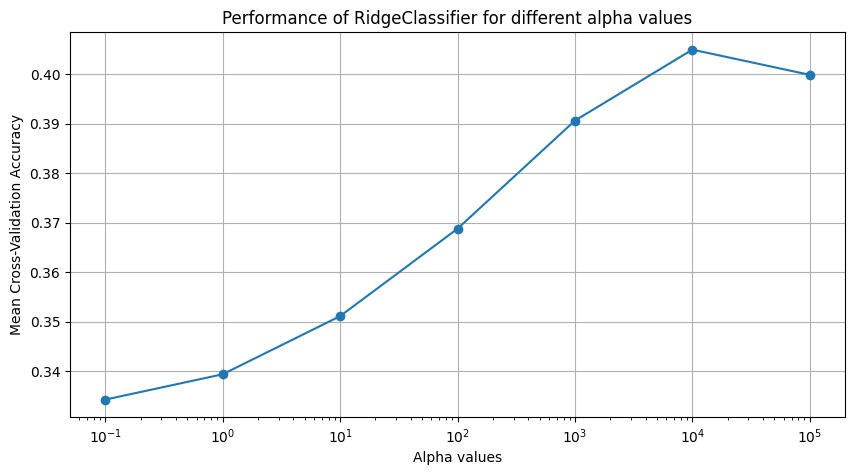

In [ ]:
def find_best_alpha(alphas: list, X_train: np.ndarray, y_train: np.ndarray) -> float:
    """Performs GridSearchCV to find the best alpha for the RidgeClassifier model.

    Args:
        alphas: A list of alpha values to try.
        X_train: The training set.
        y_train: The labels of the training set.

    Returns:
        float: The best alpha value.
    """
    # Defines the cross validation method
    grid_search = GridSearchCV(
        RidgeClassifier(tol=1e-7, random_state=888),
         param_grid={'alpha': alphas},
        cv=3,
        verbose=3
    )

    # Performs grid search on the training set with differnt alphas
    grid_search.fit(X_train, y_train.reshape(-1))

    # Extracts the mean test scores for each alpha
    mean_scores = grid_search.cv_results_['mean_test_score']

    # Plots the results
    plt.figure(figsize=(10, 5))
    plt.plot(alphas, mean_scores, marker='o')
    plt.xlabel('Alpha values')
    plt.ylabel('Mean Cross-Validation Accuracy')
    plt.title('Performance of RidgeClassifier for different alpha values')

    # Uses log scale for alpha values
    plt.xscale('log')
    plt.grid(True)
    plt.show()

    return grid_search.best_params_['alpha']


# Performs Grid Search over the hyperparameter space composed of different alpha values
alpha = find_best_alpha(
    alphas=[0.1, 1, 10, 100, 1000, 10000, 100000],
    X_train=X_train_f,
    y_train=y_train
)

In Ridge Regression, the hyperparameter alpha controls the strength of L2 regularization applied to the model, affecting the balance between minimizing the quadratic term and penalizing large coefficients. To determine the optimal value of alpha, a grid search method is typically employed, systematically evaluating model performance across a range of possible values.

It's possible to observe that for the value 100000, the model is giving too much weight on the regularization term, shrinking too much the weights and applying too much generalization, which results in underfitting the training set.

The grid search was also conducted using a dataset transformed by PCA, and the results confirmed that the current alpha value remains optimal in this transformed feature space. This further reinforces the robustness of the selected hyperparameter value across different data representations.

---
**Ridge Regression for Classification**

In [ ]:
# Creates a Ridge Classifier model
ridge_model = RidgeClassifier(alpha=10000, tol=1e-7)

# Original flattened dataset
# Starts timer to measure training time
start_time = time()
ridge_model.fit(X_train_f, y_train.reshape(-1))
ridge_f_time = time() - start_time

# Computes the score
ridge_score_f = ridge_model.score(X_test_f, y_test)

# PCA dataset
# Starts timer to measure training time
start_time = time()
ridge_model.fit(X_train_pca, y_train.reshape(-1))
ridge_pca_time = time() - start_time

# Computes the score
ridge_score_pca = ridge_model.score(X_test_pca, y_test)

# Creates a dataframe with the computed data
perf_df = pd.DataFrame({
    'model': ['RidgeClassifier', 'RidgeClassifier'],
    'dataset': ['Original', 'PCA'],
    'time': [ridge_f_time, ridge_pca_time],
    'accuracy': [ridge_score_f, ridge_score_pca]
})

In multiclass classification, the RidgeClassifier approaches the task by treating it as a multi-output regression problem. For each class, a separate regression model is trained, and the predicted class corresponds to the one with the highest predicted value across all outputs.

---
**Performance Comparison**

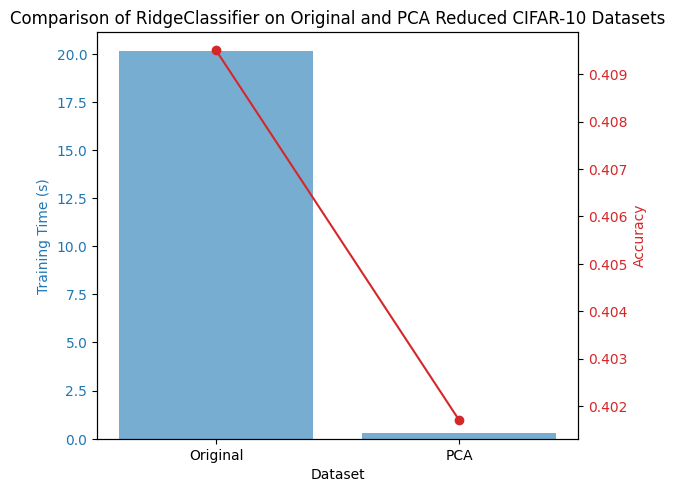

Model: RidgeClassifier
Time reduction: 98.60%
Accuracy reduction: 1.90%


In [ ]:
def compare_flattened_pca_performance(model_name: str, perf_data: pd.DataFrame) -> None:
    """Plots the performances of a ML model over both original and PCA dataset.

    Args:
        model_name: The ML model's name.
        perf_data: A pandas DataFrame containing the model time and accuracy for both datasets.
    """
    # Plotting
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Training Time (s)', color=color)
    ax1.bar(perf_data['dataset'], perf_data['time'], color=color, alpha=0.6, label='Training Time (s)')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(perf_data['dataset'], perf_data['accuracy'], color=color, marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Comparison of {model_name} on Original and PCA Reduced CIFAR-10 Datasets')
    plt.show()


def compute_performance_reduction(model_name: str, perf_data: pd.DataFrame) -> None:
    """Computes time and accuracy reduction between original and PCA datasets for a ML model.

    Args:
        model_name: The ML model's name.
        perf_data: A pandas DataFrame containing the model time and accuracy for both datasets.
    """
    # Time reduction
    time_0 = perf_data[perf_data['dataset'] == 'Original']['time'].values[0]
    time_1 = perf_data[perf_data['dataset'] == 'PCA']['time'].values[0]
    time_reduction = round(((time_0 - time_1) / time_0 * 100), 2)

    # Accuracy reduction
    accuracy_0 = perf_data[perf_data['dataset'] == 'Original']['accuracy'].values[0]
    accuracy_1 = perf_data[perf_data['dataset'] == 'PCA']['accuracy'].values[0]
    accuracy_reduction = round(((accuracy_0 - accuracy_1) / accuracy_0 * 100), 2)

    print(f'Model: {model_name}')
    print(f'Time reduction: {time_reduction:.2f}%')
    print(f'Accuracy reduction: {accuracy_reduction:.2f}%')


# Plots the performances of the model for both datasets
compare_flattened_pca_performance(model_name='RidgeClassifier', perf_data=perf_df[perf_df['model'] == 'RidgeClassifier'])

# Ouputs the time and accuracy reduction between original and pca dataset
compute_performance_reduction(model_name='RidgeClassifier', perf_data=perf_df[perf_df['model'] == 'RidgeClassifier'])

As shown in the plot, training the model on the original dataset took 20.12 seconds, achieving an accuracy of 40.95%. After applying PCA to reduce the dataset's dimensionality, the training time dropped to just 0.28 seconds, while the accuracy slightly decreased to 40.17%.

This represents a 98.60% reduction in training time but comes with a 1.90% drop in accuracy. While the time efficiency is significant, the accuracy remains low. This decline in performance is notable given that the model already performs poorly. The primary issue lies in the model's inherent design bias, as it assumes a linear combination between input features and label.

# **Random Forest**

---
**Random Search for Hyperparameters**

In [ ]:
# 1 ora 20 minuti
# Creates a base Random Forest model
base_rf_model = RandomForestClassifier(
    bootstrap=True,     # Allows bagging (with replacement)
    max_samples=0.63,   # Typical value for sampling with bagging used in literature
    n_jobs=-1,
    random_state=888
)

# Defines a search space
rf_search_space = {
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'max_depth': [10, 20, 30, 40, 50, 60, 70],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

# Random search of parameters, using 3 fold cross validation, search across 10 different combinations
rf_random = RandomizedSearchCV(estimator=base_rf_model, param_distributions=rf_search_space, n_iter=10, cv=3, verbose=3, random_state=888)
rf_random.fit(X_train_f, y_train.reshape(-1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.430 total time=  58.0s
[CV 2/3] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.425 total time=  49.7s
[CV 3/3] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.427 total time=  49.9s
[CV 1/3] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=150;, score=0.447 total time= 1.2min
[CV 2/3] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=150;, score=0.443 total time= 1.3min
[CV 3/3] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=150;, score=0.440 total time= 1.2min
[CV 1/3] END max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=250;, score=0.453 total time= 1.9min
[CV 2/3] END max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=250;, score=0.457 total tim

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    max_samples=0.63,
                                                    min_samples_leaf=5,
                                                    min_samples_split=10,
                                                    n_jobs=-1,
                                                    random_state=888),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 5, 7, 10, 15,
                                                              20],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350]},
                   random_state=888, verbose=3)

Random Forest is an ensemble learning method that relies on aggregating the predictions of multiple decision tree classifiers to improve accuracy and robustness. While effective, Random Forest models can be sensitive to the configuration of hyperparameters, with varying settings potentially influencing the bias-variance tradeoff. Poorly chosen hyperparameters can lead to either overfitting (high variance) or underfitting (high bias), affecting model performance.

I used Random Search to optimize four key hyperparameters: `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`. Hyperparameters help manage overfitting, but they do not automatically prevent it. Due to computational constraints and time limitations, I opted for Random Search instead of Grid Search. In this case, I limited the search to 10 configurations across the search space and performed 3-fold cross-validation.

This process took 1 hour and 20 minutes to complete. While it is likely that higher-performing configurations could still be found, the best-performing configuration identified through Random Search included 350 estimators, a maximum depth of 60, a minimum of 10 samples required for splitting, and a minimum of 2 samples per leaf.

---
**Random Forest**

In [ ]:
# Creates a Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=350,
    max_depth=60,
    min_samples_split=10,
    min_samples_leaf=2,
    bootstrap=True,     # Allows bagging (with replacement)
    max_samples=0.63,   # Typical value for sampling with bagging used in literature
    n_jobs=-1,
    random_state=888
)

# Original flattened dataset
# Starts timer to measure training time
start_time = time()
rf_model.fit(X_train_f, y_train.reshape(-1))
rf_f_time = time() - start_time

# Computes the score
rf_score_f = rf_model.score(X_test_f, y_test)

# PCA dataset
# Starts timer to measure training time
start_time = time()
rf_model.fit(X_train_pca, y_train.reshape(-1))
rf_pca_time = time() - start_time

# Computes the score
rf_score_pca = rf_model.score(X_test_pca, y_test)

# Adds to the dataframe the new data
perf_df = pd.concat([perf_df, pd.DataFrame({
    'model': ['RandomForest', 'RandomForest'],
    'dataset': ['Original', 'PCA'],
    'time': [rf_f_time, rf_pca_time],
    'accuracy': [rf_score_f, rf_score_pca]
})], ignore_index=True)

---
**Performance Comparison**

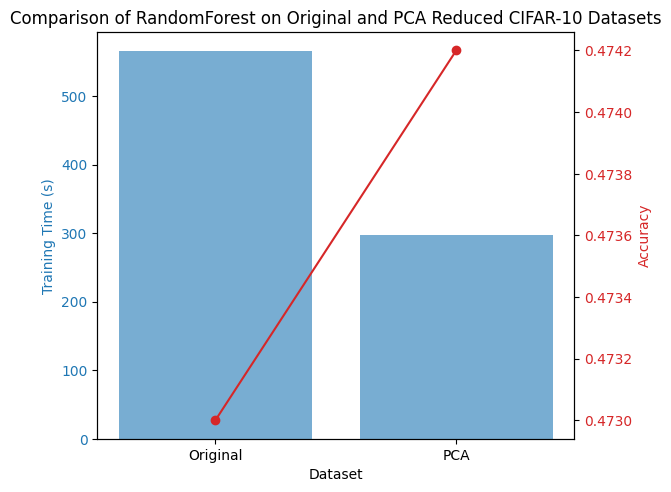

Model: RandomForest
Time reduction: 47.46%
Accuracy reduction: -0.25%


In [ ]:
compare_flattened_pca_performance(model_name='RandomForest', perf_data=perf_df[perf_df['model'] == 'RandomForest'])
compute_performance_reduction(model_name='RandomForest', perf_data=perf_df[perf_df['model'] == 'RandomForest'])

As shown in the plot, training the model on the original dataset took 9 minutes and 25 seconds, achieving an accuracy of 47.30%. After applying PCA to reduce the dataset's dimensionality, the training time dropped to 4 minutes and 56 seconds, while the accuracy slightly increased to 47.42%.

This represents a 47.46% reduction in training time and a 0.25% increase in accuracy. The improvement in both efficiency and performance is related to the fact that decision trees tend to favor orthogonal decision boundaries that are aligned with feature axes. Due to this characteristic, decision trees can be sensitive to the orientation of data. When data is not aligned with the axes, such as when it is rotated, the model may require more complex and deeper splits to generalize, potentially leading to reduced performance.

PCA addresses this issue by transforming the feature space, reorienting the data along principal components that capture the maximum variance. This effectively aligns the decision boundaries in a way that simplifies the decision-making process for the tree. Scaling the data before applying PCA further enhances this effect by ensuring that all features contribute equally to the principal components, improving the tree's ability to generalize well.

# **Deep CNN**

---
**Data Augmentation**

In [ ]:
# Define data augmentation for training
def augment(image, label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40)  # Add padding
    image = tf.image.random_crop(image, size=[32, 32, 3])    # Random crop back to 32x32
    image = tf.image.random_flip_left_right(image)           # Random horizontal flip
    return image, label

X_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
X_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Apply preprocessing and augmentation
X_train = X_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
X_train = X_train.shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

X_val = X_val.batch(256).prefetch(tf.data.AUTOTUNE)

---
**Optimal Cell Architecture using NAS-Bench-101**

Utilizing NAS-Bench-101 from Google Research, I conducted a random search algorithm over the 108-epoch dataset to identify the optimal cell architecture. The search involved evaluating 20 different architectures to select the most effective one.

Optimal Architecture Matrix:

\begin{bmatrix}
0 & 1 & 1 & 1 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0
\end{bmatrix}

Optimal Architecture Operations:  
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']


Validation Accuracy of Optimal Architecture:  94.72%  
Test Accuracy of Optimal Architecture:  93.78%

---
**Deep CNN Model**

In [ ]:
def create_cell(input_tensor, filters, stack_id, cell_id):
    # Node 0: Input
    projected_tensor = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, padding='same', kernel_initializer="he_normal", name=f'Proj_Cell_{stack_id}_{cell_id}')(input_tensor)

    # Node 1: Conv3x3-BN-ReLU
    x1_input = projected_tensor
    x1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, padding='same', kernel_initializer="he_normal", name=f'Conv3x3_Cell_{stack_id}_{cell_id}')(x1_input)
    x1 = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=0.00001, name=f'BN_Conv3x3_Cell_{stack_id}_{cell_id}')(x1)
    x1_output = tf.keras.layers.ReLU(name=f'ReLU_Conv3x3_Cell_{stack_id}_{cell_id}')(x1)

    # Node 2: Conv1x1-BN-ReLU
    x2_input = tf.keras.layers.Add(name=f'Input_Conv3x3_Add_Cell_{stack_id}_{cell_id}')([projected_tensor, x1_output])
    x2 = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, padding='same', kernel_initializer="he_normal", name=f'Conv1x1_Cell_{stack_id}_{cell_id}')(x2_input)
    x2 = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=0.00001, name=f'BN_Conv1x1_Cell_{stack_id}_{cell_id}')(x2)
    x2_output = tf.keras.layers.ReLU(name=f'ReLU_Conv1x1_Cell_{stack_id}_{cell_id}')(x2)

    # Node 3: Output
    output = tf.keras.layers.Concatenate(name=f'Input_Conv1x1_Concat_Cell_{stack_id}_{cell_id}')([projected_tensor, x2_output])

    return output


def create_stack(input_tensor, filters, stack_nmb):
    # Cell 1
    cell1 = create_cell(input_tensor, filters, stack_nmb, 1)

    # Cell 2
    cell2 = create_cell(cell1, filters, stack_nmb, 2)

    # Cell 3
    cell3 = create_cell(cell2, filters, stack_nmb, 3)

    return cell3


def build_CNN_model():
    # Input layer
    inputs = tf.keras.Input(shape=(32, 32, 3), name='Input')

    # Stem layer
    stem = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu", kernel_initializer="he_normal", name='Stem')(inputs)

    # Stack 1
    stack1 = create_stack(stem, 128, 1)

    # Downsample layer
    down1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(stack1)

    # Stack 2
    stack2 = create_stack(down1, 128 * 2, 2)

    # Downsample layer
    down2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool2')(stack2)

    # Stack 3
    stack3 = create_stack(down2, 128 * 2 * 2, 3)

    # Global Average Pooling
    glb_avg_pool = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAvgPool')(stack3)

    # Output layer
    outputs = tf.keras.layers.Dense(10, activation="softmax", name='Dense_1')(glb_avg_pool)

    # Create model
    model = tf.keras.Model(inputs, outputs)

    return model


# Creates the Deep CNN model
model = build_CNN_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Stem (Conv2D)             │ (None, 32, 32, 128)    │          3,584 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Proj_Cell_1_1 (Conv2D)    │ (None, 32, 32, 128)    │         16,512 │ Stem[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv3x3_Cell_1_1 (Conv2D) │ (None, 32, 32, 128)    │        147,584 │ Proj_Cell_1_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BN_Conv3x3_Cell_1_1       │ (None, 32, 32, 128)    │            512 │ Conv3x3_Cell_1_1[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ReLU_Conv3x3_Cell_1_1     │ (None, 32, 32, 128)    │              0 │ BN_Conv3x3_Cell_1_1[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Conv3x3_Add_Cell_1… │ (None, 32, 32, 128)    │              0 │ Proj_Cell_1_1[0][0],   │
│ (Add)                     │                        │                │ ReLU_Conv3x3_Cell_1_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1x1_Cell_1_1 (Conv2D) │ (None, 32, 32, 128)    │         16,512 │ Input_Conv3x3_Add_Cel… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BN_Conv1x1_Cell_1_1       │ (None, 32, 32, 128)    │            512 │ Conv1x1_Cell_1_1[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ReLU_Conv1x1_Cell_1_1     │ (None, 32, 32, 128)    │              0 │ BN_Conv1x1_Cell_1_1[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Conv1x1_Concat_Cel… │ (None, 32, 32, 256)    │              0 │ Proj_Cell_1_1[0][0],   │
│ (Concatenate)             │                        │                │ ReLU_Conv1x1_Cell_1_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Proj_Cell_1_2 (Conv2D)    │ (None, 32, 32, 128)    │         32,896 │ Input_Conv1x1_Concat_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv3x3_Cell_1_2 (Conv2D) │ (None, 32, 32, 128)    │        147,584 │ Proj_Cell_1_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BN_Conv3x3_Cell_1_2       │ (None, 32, 32, 128)    │            512 │ Conv3x3_Cell_1_2[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ReLU_Conv3x3_Cell_1_2     │ (None, 32, 32, 128)    │              0 │ BN_Conv3x3_Cell_1_2[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Conv3x3_Add_Cel

 Total params: 12,085,642 (46.10 MB)

 Trainable params: 12,074,890 (46.06 MB)

 Non-trainable params: 10,752 (42.00 KB)

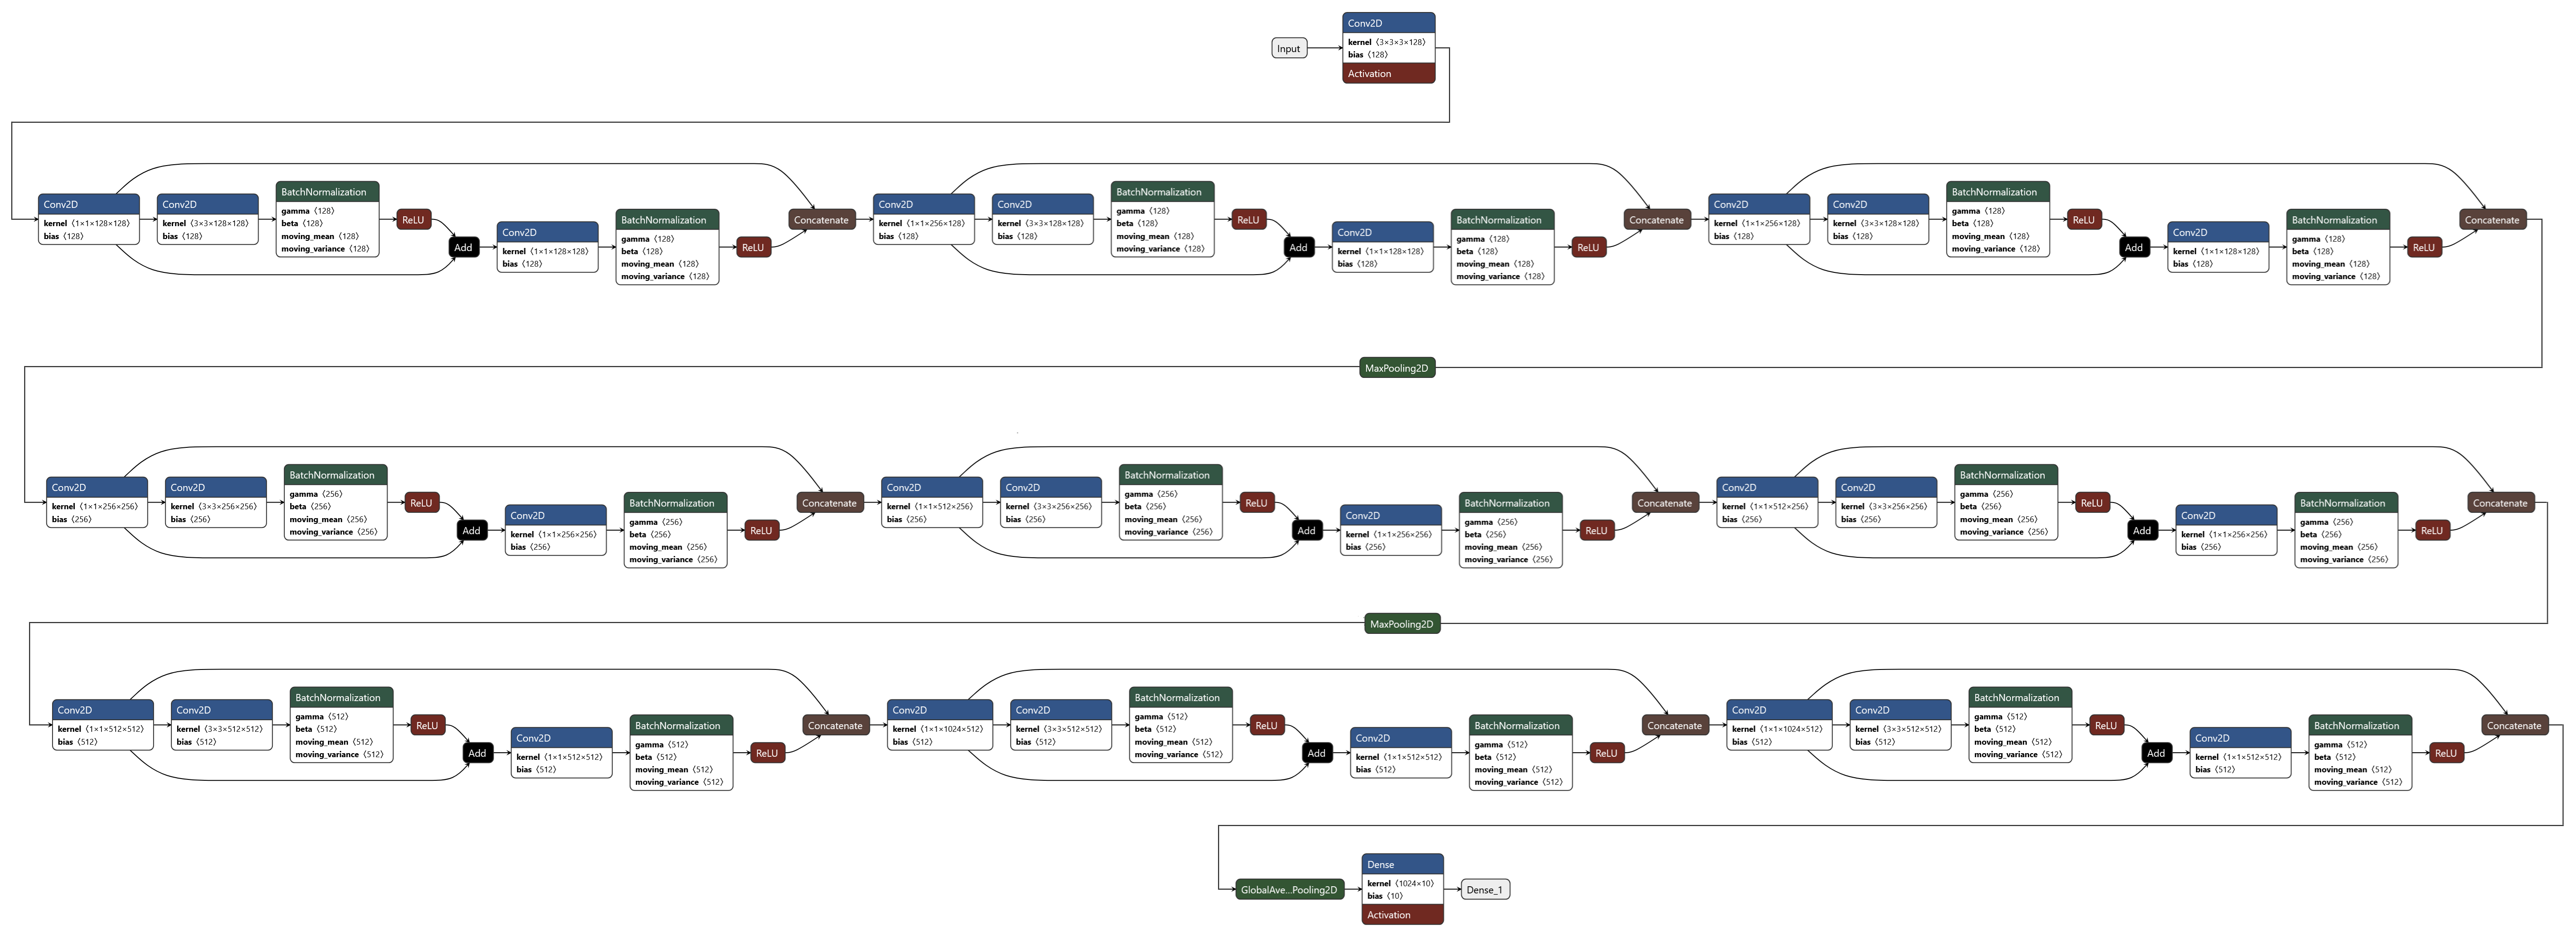

As outlined in the paper, the CNN architecture is structured as follows:
- A stem convolution layer (3x3 Conv2D with Batch Normalization and ReLU activation)
- A stack of 3 cells
- A downsampling layer (MaxPooling)
- Another stack of 3 cells
- A second downsampling layer (MaxPooling)
- A final stack of 3 cells
- A global average pooling layer
- A dense layer with Softmax activation

The non-trainable parameters in this architecture are derived from the Batch Normalization layers.

---
**Model Training**

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

epochs = 108

# You can now compile your model using this optimizer
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # or any other loss appropriate for your task
    metrics=['accuracy']
)

# Creates an Early-Stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)

# Creates a checkpoint callback
checkpoint_filepath = 'deep_cnn_model.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

start_time = time()
# Train the model 1 ora 24 minuti
history = model.fit(
    X_train,
    batch_size=256,
    epochs=epochs,
    validation_data=X_val,
    callbacks=[model_checkpoint_callback, es_callback]
)
cnn_time = time() - start_time

Epoch 1/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 362ms/step - accuracy: 0.3053 - loss: 3.9094 - val_accuracy: 0.1715 - val_loss: 10.0372
Epoch 2/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 300ms/step - accuracy: 0.5585 - loss: 1.2432 - val_accuracy: 0.4006 - val_loss: 2.3774
Epoch 3/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 300ms/step - accuracy: 0.6581 - loss: 0.9604 - val_accuracy: 0.4893 - val_loss: 2.1231
Epoch 4/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 300ms/step - accuracy: 0.7159 - loss: 0.7978 - val_accuracy: 0.5549 - val_loss: 2.0126
Epoch 5/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - accuracy: 0.7552 - loss: 0.6947 - val_accuracy: 0.6873 - val_loss: 1.0402
Epoch 6/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - accuracy: 0.7930 - loss: 0.5954 - val_accuracy: 0.7037 - val_loss: 0.9159
Epoch 7/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 297ms/step - accuracy: 0.8056 - loss: 0.5573 - val_accuracy: 0.6943 - val_loss: 1.0045
Epoch 8/108
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - accuracy: 0.8261 

The model was trained for 108 epochs with a batch size of 256, utilizing standard data augmentation techniques, as specified in the paper. The training process for the deep CNN model took 1 hour, 24 minutes, and 10 seconds to complete.

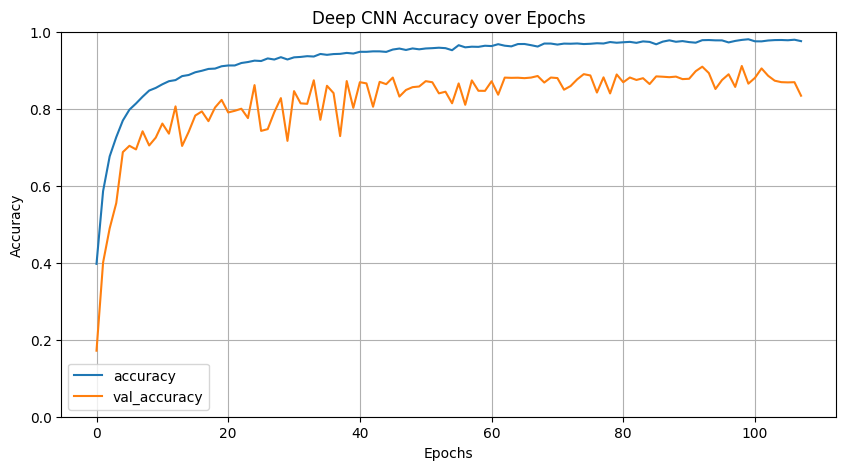

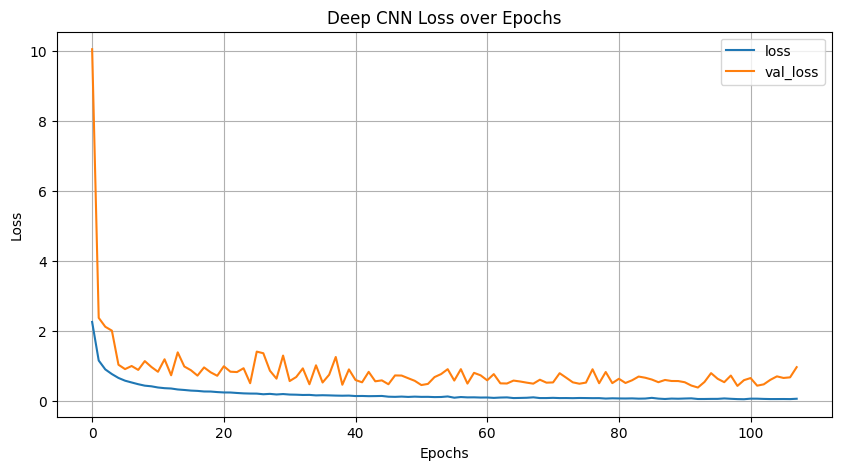

In [ ]:
# Plots the loss and the accuracy for both training and validation sets
cnn_data = pd.DataFrame(history.history)

cnn_data[['accuracy', 'val_accuracy']].plot(figsize=(10, 5))
plt.grid(True)
plt.title("Deep CNN Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.gca().set_ylim(0, 1)
plt.show()

cnn_data[['loss', 'val_loss']].plot(figsize=(10, 5))
plt.grid(True)
plt.title("Deep CNN Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

---
**Model Evaluation**

In [ ]:
# Evaluates the performance of the model on the testing set
cnn_loss, cnn_accuracy = model.evaluate(X_test, y_test)

perf_df = pd.concat([perf_df, pd.DataFrame({
    'model': ['DeepCNN'],
    'dataset': ['Original'],
    'time': [cnn_time],
    'accuracy': [cnn_accuracy]
})], ignore_index=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9006 - loss: 0.4767


The deep CNN model achieved 91.1% accuracy on the validation set and 90% accuracy on the test set. The approximately 4% drop in expected performance could be attributed to differences in the training setup. Specifically, in the paper, the researchers utilized a different optimizer with a particular learning rate decay schedule, which I did not replicate in my training process.

# **Conclusions**

---
**Models Comparison**


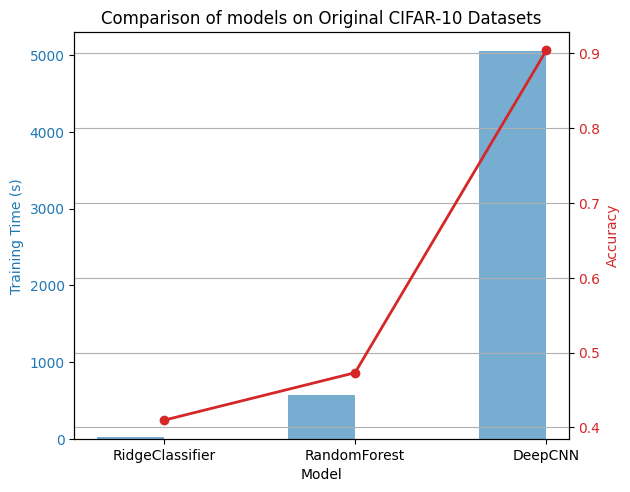

In [ ]:
def compare_models_performance(perf_data: pd.DataFrame) -> None:
    # Plotting
    fig, ax1 = plt.subplots()

    bar_width = 0.35
    index = np.arange(len(perf_data))

    # Bar chart for Training Time
    color = 'tab:blue'
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Training Time (s)', color=color)
    bars = ax1.bar(index, perf_data['time'], bar_width, color=color, alpha=0.6, label='Training Time (s)')
    ax1.tick_params(axis='y', labelcolor=color)

    # Line plot for Accuracy
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(index + bar_width / 2, perf_data['accuracy'], color=color, marker='o', linewidth=2, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Set the x-axis labels
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(perf_data['model'])

    # Tight layout to avoid overlap
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # Title of the plot
    plt.title(f'Comparison of models on Original CIFAR-10 Datasets')
    plt.grid(True)
    plt.show()


# Assuming you have the perf_df DataFrame already loaded with a 'model' column
compare_models_performance(perf_data=perf_df[perf_df['dataset'] == 'Original'])

In the plot, all 3 models are compared on the original dataset. As expected, there a linear positive correlation between model complexity and both accuracy and training time. Ridge Regression and Random Forest were trained on CPU, while the Deep CNN model was trained on L4 GPU.